In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from synthetic_networks.random_network import *
from synthetic_networks.bba import *
import itertools

In [2]:
# generates a directed, scale-free graph with minority fraction fm
G = Random(N=1000, 
               fm=0.5, 
               d=0.1,
               verbose=False)

### Random Walk Sampling

Taken from Wagner et al. (2017):

This strategy samples nodes by walking through the network. The walker starts at a random node in the network and chooses in each step one out-going link randomly and traverses it. All visited nodes are then added to the sample until K nodes have been added. A teleport probability can be set for teleporting to another random node in the network instead of traversing a link in this iteration; we use 0.15 throughout this work. The sampled network then contains these K nodes and all links between them. This technique of sampling is usually used in online social networks such as Facebook or Twitter, in
which retrieving information about the whole population is overwhelming and computationally costly, but we can access and navigate the original network.

In [144]:
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt

class RandomWalker:
    def __init__(self, full_network, sample_size):
        assert full_network.number_of_nodes() > sample_size
        self.full_network = full_network
        self.sample_size = sample_size
        self.sampled_network = None
    
    def add_distinct_k0(self, network, node):
        if node not in [n for n in network.nodes()]:
            network.add_node(node)

    def get_all_valid_edges_between_sampled_nodes(self, full_network, sampled_network):
        all_possible_edges = list(itertools.combinations([n for n in sampled_network.nodes()], 2))

        for e in all_possible_edges:
            if full_network.has_edge(e[0], e[1]):
                sampled_network.add_edge(e[0], e[1])
            elif full_network.has_edge(e[1], e[0]):
                sampled_network.add_edge(e[1], e[0])

        return sampled_network

    def draw_sample(self):
        assert self.sampled_network != None
        nx.draw(self.sampled_network)
        plt.show()
        
    def get_random_walk_sampled_network(self, teleportation_proba=0.15):
    
        # get list of all nodes in the network
        all_nodes  = [n for n in self.full_network.nodes()]

        # randomly choose 1 node as starting point
        k_0 = np.random.choice(all_nodes, 1)[0]

        # initialize empty, directed networkx graph
        self.sampled_network = nx.DiGraph()
        self.sampled_network.add_node(k_0)

        i = self.sampled_network.number_of_nodes()

        while i < self.sample_size:
            
            # get a list of all nodes with an in-edge from k_0
            out_nodes_k0 = [tup[1] for tup in self.full_network.out_edges(k_0)]
            
            # draw random number to determine whether the walker traverses an edge or teleports
            traversion_threshold = (np.random.randint(1, 100)) / 100

            # traverse an edge with probability equal to 1-teleportation_proba
            if traversion_threshold <= (1-teleportation_proba):

                # if node k_0 has at least one outgoing edge, draw a random destination node
                # and add node k_1 to the network
                if len(out_nodes_k0) > 0:
                    k_1 = np.random.choice(out_nodes_k0, 1)[0]
                    self.sampled_network.add_node(k_1)
                    # add k_0 if not already in nodes
                    self.add_distinct_k0(self.sampled_network, k_0)
                
                # if node k_0 does not have any outgoing edges and is not yet in nodes, add node k_0 to graph
                # in this case, pick new random k_1 node from all possible nodes (where k_1 !=  k_0)
                # TODO: determine if this is actually useful / needed
                else:
                    k_1 = np.random.choice([node for node in all_nodes if node != k_0], 1)[0]
                    self.sampled_network.add_node(k_1)
                    # add k_0 if not already in nodes
                    self.add_distinct_k0(self.sampled_network, k_0)
            
            # teleport to a random node
            else:
                # remove connected nodes from possible teleportation destinations
                teleportation_destinations = [node for node in all_nodes if node not in out_nodes_k0]
                # randomly pick a teleportation destination node
                k_1 = np.random.choice(teleportation_destinations, 1)[0]
                # add this node to the sampled network
                self.sampled_network.add_node(k_1)
                # add k_0 if not already in nodes
                self.add_distinct_k0(self.sampled_network, k_0)

            # update the new starting node to be the previous destination node
            k_0 = k_1

            i = self.sampled_network.number_of_nodes()
        
        self.sampled_network = self.get_all_valid_edges_between_sampled_nodes(self.full_network, self.sampled_network)
        
        return self.sampled_network


In [145]:
rw = RandomWalker(full_network=G, sample_size=100)
sample = rw.get_random_walk_sampled_network(teleportation_proba=0.15)

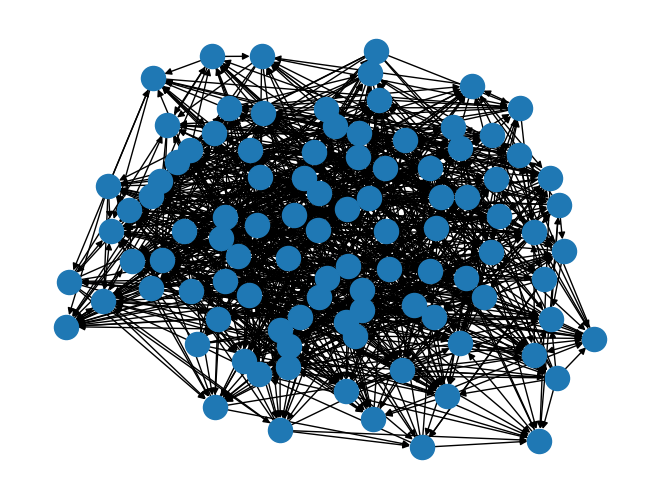

In [146]:
rw.draw_sample()

----------------------------------------------------------------------------------------------------

In [103]:
# EXPERIMENTAL

SAMPLE_SIZE = 100

all_nodes  = [n for n in G.nodes()]
k_0 = np.random.choice(all_nodes, 1)[0]

sampled_network = nx.DiGraph()

for i in range(SAMPLE_SIZE):
    
    out_edges_k0 = [tup[1] for tup in G.out_edges(k_0)]
    
    traversion_proba = np.random.randint(1, 100)

    if traversion_proba <= 85:
        if len(out_edges_k0) > 0:
            k_1 = np.random.choice(out_edges_k0, 1)[0]
            sampled_network.add_edge(k_0, k_1)
        else:
            sampled_network.add_node(k_0)
            k_1 = np.random.choice(all_nodes, 1)[0]
    
    else:
        k_1 = np.random.choice(all_nodes, 1)[0]
        sampled_network.add_node(k_1)
        sampled_network.add_node(k_0)

    k_0 = k_1
    


In [57]:
aG = DPA(N=1000, 
        fm=0.5, 
        d=0.01, 
        plo_M=2.5, 
        plo_m=2.5,
        verbose=False)

In [62]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.histplot(degrees)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


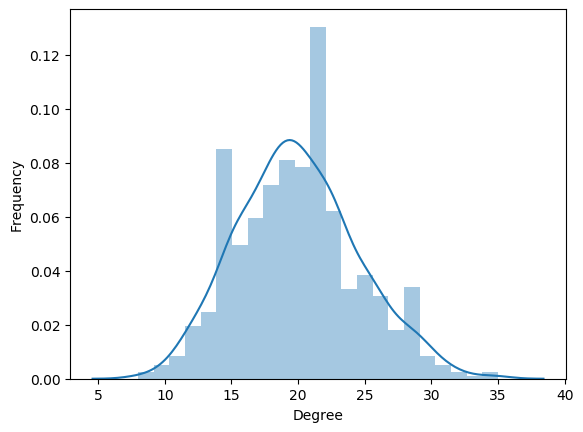

In [70]:
plot_degree_dist(G)

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


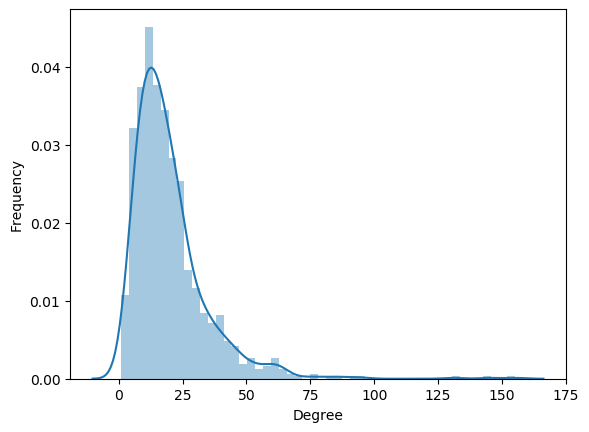

In [64]:
plot_degree_dist(aG)

In [67]:
def plot_degree_dist_per_group(G):
    male_degrees = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1]['gender'] == 0]
    female_degrees = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1]['gender'] == 1]
    
    plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
    plt.hist(male_degrees)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.title('Male')
    plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
    plt.hist(female_degrees)
    plt.xlabel('Degree')
    plt.title('Female')

    plt.show()

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


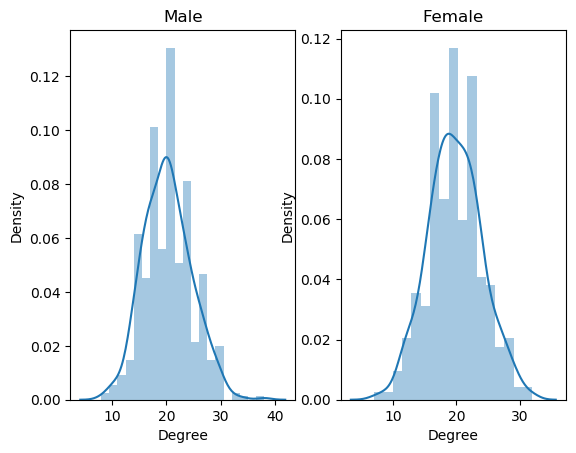

In [68]:
plot_degree_dist_per_group(G)